# Imports

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
import scikitplot as skplt
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, f1_score,auc,roc_curve,roc_auc_score, precision_recall_curve
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, ParameterGrid
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.svm import SVC
import pickle
from scipy import stats
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from tqdm import tqdm
import datetime
import time
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, StratifiedKFold, KFold
from sklearn.decomposition import PCA

# Global Var

In [2]:
KFOLDS=10

# Data Processing & EDA

In [3]:
train_data = pd.read_csv("train.csv",encoding="utf_8_sig")
print(train_data.shape)
print(list(train_data), len(list(train_data)))
train_data.head()

(9681, 25)
['id', 'neighbourhood', 'room_type', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'host_since', 'host_is_superhost', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'cleaning_fee', 'guests_included', 'extra_people', 'maximum_nights', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'price'] 25


,id,neighbourhood,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,host_since,...,cleaning_fee,guests_included,extra_people,maximum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,price
0,727,Palermo,Entire home/apt,1,170,5/12/20,2.48,4,346,8/1/13,...,2092,1,0,365,t,f,strict_14_with_grace_period,f,f,2
1,6274,Colegiales,Private room,1,11,7/1/19,0.57,1,0,2/14/14,...,558,1,0,15,f,f,moderate,f,f,1
2,6025,Recoleta,Entire home/apt,3,2,11/23/19,0.08,19,360,10/19/17,...,1052,3,351,90,t,f,moderate,f,f,3
3,8931,Recoleta,Entire home/apt,2,1,11/1/19,0.13,1,267,2/1/19,...,0,4,0,1125,t,f,flexible,f,f,2
4,7524,San Nicolás,Entire home/apt,2,31,12/26/19,1.54,5,365,1/24/15,...,2092,1,0,365,t,f,moderate,f,f,3


In [4]:
neigh_encoder = LabelBinarizer()
room_encoder = LabelBinarizer()
bed_encoder = LabelBinarizer()
cancel_encoder = LabelBinarizer()
neigh_encoder.fit(train_data['neighbourhood'])
room_encoder.fit(train_data['room_type'])
bed_encoder.fit(train_data['bed_type'])
cancel_encoder.fit(train_data['cancellation_policy'])

def data_processing_onehotencode(data):
    current_date = ["11/03/20"]*len(data["number_of_reviews"])
    data["today_date"] = current_date
    data["last_review"] = (pd.to_datetime(data['today_date']) - pd.to_datetime(data['last_review']))
    data["host_since"] = (pd.to_datetime(data['today_date']) - pd.to_datetime(data['host_since']))
    data['last_review'] = data["last_review"].astype('timedelta64[D]').astype(float)
    data['host_since'] = data["host_since"].astype('timedelta64[D]').astype(float)
    data = data.drop(["today_date"],axis=1)
    
    def room_type_name(i):
        def_code = {"Entire home/apt":1,'Private room': 2,'Shared room':3,'Hotel room':4}
        if i in def_code:
            return def_code[i]
    def bed_type_name(i):
        def_code = {'Real Bed':1,'Pull-out Sofa': 2,'Futon':3,'Couch':4,'Airbed':5}
        if i in def_code:
            return def_code[i]
    def cancellation_policy_name(i):
        def_code = {'strict_14_with_grace_period':1,'flexible': 2,'moderate':3,'super_strict_30':4, 'super_strict_60':5}
        if i in def_code:
            return def_code[i]
    
    def encode_onehot(name, d):
        
        encoder = LabelBinarizer()
        jobs_encoder.fit(data['Profession'])
        transformed = jobs_encoder.transform(data['Profession'])
        ohe_df = pd.DataFrame(transformed)
        
        onehot_ = pd.get_dummies(d[name], prefix=name)
        d.drop(name, axis=1, inplace=True)
        d = pd.concat([onehot_, d], axis=1)
        return d
    
    neigh_onehot = neigh_encoder.transform(data['neighbourhood'])
    neigh_onehot_df = pd.DataFrame(neigh_onehot)
    data.drop('neighbourhood', axis=1, inplace=True)
    data = pd.concat([neigh_onehot_df, data], axis=1)
    
    room_onehot = room_encoder.transform(data['room_type'])
    room_onehot_df = pd.DataFrame(room_onehot)
    data.drop('room_type', axis=1, inplace=True)
    data = pd.concat([room_onehot_df, data], axis=1)
    
    bed_onehot = bed_encoder.transform(data['bed_type'])
    bed_onehot_df = pd.DataFrame(bed_onehot)
    data.drop('bed_type', axis=1, inplace=True)
    data = pd.concat([bed_onehot_df, data], axis=1)
    
    cancel_onehot = cancel_encoder.transform(data['cancellation_policy'])
    cancel_onehot_df = pd.DataFrame(cancel_onehot)
    data.drop('cancellation_policy', axis=1, inplace=True)
    data = pd.concat([cancel_onehot_df, data], axis=1)

#     data['neighbourhood'] = data.neighbourhood.apply(neigh_name)
#     data['room_type'] = data.room_type.apply(room_type_name)
#     data['bed_type'] = data.bed_type.apply(bed_type_name)
#     data['cancellation_policy'] = data.cancellation_policy.apply(cancellation_policy_name)

    data['host_is_superhost'] = data.host_is_superhost.map(dict(t=2, f=1))
    data['instant_bookable'] = data.instant_bookable.map(dict(t=2, f=1))
    data['require_guest_profile_picture'] = data.require_guest_profile_picture.map(dict(t=2, f=1))
    data['require_guest_phone_verification'] = data.require_guest_phone_verification.map(dict(t=2, f=1))
    
    data.drop('id', axis=1, inplace=True)
    
    data = data.drop(["is_business_travel_ready"],axis=1)
    
    return data

In [5]:
def data_processing_labelencode(data):
    current_date = ["11/03/20"]*len(data["number_of_reviews"])
    data["today_date"] = current_date
    data["last_review"] = (pd.to_datetime(data['today_date']) - pd.to_datetime(data['last_review']))
    data["host_since"] = (pd.to_datetime(data['today_date']) - pd.to_datetime(data['host_since']))
    data['last_review'] = data["last_review"].astype('timedelta64[D]').astype(float)
    data['host_since'] = data["host_since"].astype('timedelta64[D]').astype(float)
    data = data.drop(["today_date"],axis=1)
    
    def neigh_name(i):
        def_code = {"Palermo":1,"Colegiales":2,"Recoleta":3,"San Nicolás":4,"Caballito":5,"Núñez":6,"Balvanera":7,
                    "Constitución":7,"Monserrat":8,"Retiro":9,"San Telmo":10,"Belgrano":11,"Villa Devoto":12,
                    "Puerto Madero":13,"Almagro":14,"Villa Santa Rita":15,"Villa Crespo":16,"Villa Urquiza":17,"Parque Patricios":18,
                    "Coghlan":19,"Flores":20,"Barracas":21,"Agronomía":22,"Chacarita":23,"Villa Ortúzar":24,"Villa del Parque":25,
                    "Saavedra":26,"Villa Pueyrredón":27,"Parque Chacabuco":28,"Parque Chas":29,"Boedo":30,"Monte Castro":31,
                    "Floresta":32,"La Paternal":33,"La Boca":34,"San Cristóbal":35,"Villa Luro":36,"Liniers":37,"Mataderos":38,"Villa General Mitre":39,
                    "Parque Avellaneda":40,"Nueva Pompeya":41,"Versalles":42,"Vélez Sársfield":43,"Villa Real":44}
        if i in def_code:
            return def_code[i]
    def room_type_name(i):
        def_code = {"Entire home/apt":1,'Private room': 2,'Shared room':3,'Hotel room':4}
        if i in def_code:
            return def_code[i]
    def bed_type_name(i):
        def_code = {'Real Bed':1,'Pull-out Sofa': 2,'Futon':3,'Couch':4,'Airbed':5}
        if i in def_code:
            return def_code[i]
    def cancellation_policy_name(i):
        def_code = {'strict_14_with_grace_period':1,'flexible': 2,'moderate':3,'super_strict_30':4, 'super_strict_60':5}
        if i in def_code:
            return def_code[i]
    
    data['neighbourhood'] = data.neighbourhood.apply(neigh_name)
    data['room_type'] = data.room_type.apply(room_type_name)
    data['bed_type'] = data.bed_type.apply(bed_type_name)
    data['cancellation_policy'] = data.cancellation_policy.apply(cancellation_policy_name)

    data['host_is_superhost'] = data.host_is_superhost.map(dict(t=2, f=1))
    data['instant_bookable'] = data.instant_bookable.map(dict(t=2, f=1))
    data['require_guest_profile_picture'] = data.require_guest_profile_picture.map(dict(t=2, f=1))
    data['require_guest_phone_verification'] = data.require_guest_phone_verification.map(dict(t=2, f=1))
    
    data.drop('id', axis=1, inplace=True)
    
    data = data.drop(["is_business_travel_ready"],axis=1)
    
#     target = data['maximum_nights']
#     mean = target.mean()
#     std = target.std()
#     tol=10
#     data = data[(target > mean - tol*std) & (target < mean + tol*std)]
    
    return data

In [6]:
print(list(train_data))
train_data = data_processing_onehotencode(train_data)
print(list(train_data))
print(train_data.shape)

['id', 'neighbourhood', 'room_type', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'host_since', 'host_is_superhost', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'cleaning_fee', 'guests_included', 'extra_people', 'maximum_nights', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'price']
[0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'host_since', 'host_is_superhost', 'bathrooms', 'bedrooms', 'beds', 'cleaning_fee', 'guests_included', 'extra_people', 'maximum_nights', 'instant_bookable', 'require_guest_profile_picture', 'req

In [7]:
train_data

,0,1,2,3,4,0,1,2,3,4,...,bedrooms,beds,cleaning_fee,guests_included,extra_people,maximum_nights,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,price
0,0,0,1,0,0,0,0,0,0,1,...,0,1,2092,1,0,365,2,1,1,2
1,0,1,0,0,0,0,0,0,0,1,...,1,1,558,1,0,15,1,1,1,1
2,0,1,0,0,0,0,0,0,0,1,...,0,1,1052,3,351,90,2,1,1,3
3,1,0,0,0,0,0,0,0,0,1,...,1,3,0,4,0,1125,2,1,1,2
4,0,1,0,0,0,0,0,0,0,1,...,1,3,2092,1,0,365,2,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9676,0,0,1,0,0,0,0,0,0,1,...,1,1,700,1,0,185,1,1,1,4
9677,0,0,1,0,0,0,0,0,0,1,...,2,5,1500,6,500,30,2,1,1,4
9678,1,0,0,0,0,0,0,0,0,1,...,0,2,3492,1,0,180,2,1,1,3
9679,0,1,0,0,0,0,0,0,0,1,...,3,3,900,1,0,1125,2,1,1,3


In [8]:
X_unscaled = train_data.drop(columns=['price'], axis=1)
y_train = train_data['price']

In [9]:
scale = StandardScaler()
scale.fit(X_unscaled)
X_train = scale.transform(X_unscaled)

# Models

In [10]:
#Membuat fungsi yang nanti sekalin bisa training dan tes kemudian dievalusi
def model_eval(clf, X=X_train, print_=True, k=KFOLDS, cat=False):
    scores = cross_validate(clf, X, y_train, cv=k, n_jobs=-1, scoring=['roc_auc_ovo', 'accuracy'], return_train_score=True)
    if print_:
        print("Train: Acc: {:.5f} +/- {:.5f},  Auc: {:.5f} | Test: Acc: {:.5f} +/- {:.5f},  Auc: {:.5f}".
              format(scores['train_accuracy'].mean(), scores['train_accuracy'].std() * 2, scores['train_roc_auc_ovo'].mean(), 
                     scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2, scores['test_roc_auc_ovo'].mean()))
    return scores['train_accuracy'].mean(), scores['train_roc_auc_ovo'].mean(), scores['test_accuracy'].mean(), scores['test_roc_auc_ovo'].mean()

In [73]:
def plot_grid_search_validation_curve(grid, param_to_vary, log=False, model_name=None):
#     plt.figure(figsize=(5, 20))
    df_cv_results = pd.DataFrame(grid.cv_results_)
    train_scores_mean = df_cv_results['mean_train_accuracy']
    valid_scores_mean = df_cv_results['mean_test_accuracy']
    train_scores_std = df_cv_results['std_train_accuracy']
    valid_scores_std = df_cv_results['std_test_accuracy']

    param_cols = [c for c in df_cv_results.columns if c[:6] == 'param_']
    param_ranges = [grid.param_grid[p[6:]] for p in param_cols]
    param_ranges_lengths = [len(pr) for pr in param_ranges]

    train_scores_mean = np.array(train_scores_mean).reshape(*param_ranges_lengths)
    valid_scores_mean = np.array(valid_scores_mean).reshape(*param_ranges_lengths)
    train_scores_std = np.array(train_scores_std).reshape(*param_ranges_lengths)
    valid_scores_std = np.array(valid_scores_std).reshape(*param_ranges_lengths)

    param_to_vary_idx = param_cols.index('param_{}'.format(param_to_vary))

    slices = []
    for idx, param in enumerate(grid.best_params_):
        if (idx == param_to_vary_idx):
            slices.append(slice(None))
            continue
        best_param_val = grid.best_params_[param]
        idx_of_best_param = 0
        if isinstance(param_ranges[idx], np.ndarray):
            idx_of_best_param = param_ranges[idx].tolist().index(best_param_val)
        else:
            idx_of_best_param = param_ranges[idx].index(best_param_val)
        slices.append(idx_of_best_param)

    train_scores_mean = train_scores_mean[tuple(slices)]
    valid_scores_mean = valid_scores_mean[tuple(slices)]
    train_scores_std = train_scores_std[tuple(slices)]
    valid_scores_std = valid_scores_std[tuple(slices)]

    plt.clf()
    title = param_to_vary + ' vs Accuracy ' + model_name
    plt.title(title)
    plt.xlabel(param_to_vary)
    plt.ylabel('Accuracy')

    plt.ylim(0.45, 0.6)

    lw = 2

    plot_fn = plt.plot
    if log:
        plot_fn = plt.semilogx

    param_range = param_ranges[param_to_vary_idx]
#     plot_fn(param_range, train_scores_mean, label='Training Accuracy', color='r',
#             lw=lw)
#     plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color='r', lw=lw)
    plot_fn(param_range, valid_scores_mean, label='Cross-validation Accuracy',
            color='b', lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1,
                     color='b', lw=lw)

    plt.legend()

    plt.show()

# LGBM Tuning

In [13]:
lgb = LGBMClassifier(objective='multiclass',num_class=4, random_state=1, learning_rate=0.086, 
                         max_depth=10, num_leaves=200, min_child_samples=3, min_child_weight=0.007,
                        reg_alpha = 0.8, reg_lambda=0.8)
model_eval(lgb)

Acc: 0.55511 +/- 0.02413 | Auc: 0.80195


(0.5551082764093745, 0.8019513149131952)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed:    0.8s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    1.0s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed:    1.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    1.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.4s finished



 The best estimator across ALL searched params:
 LGBMClassifier(learning_rate=0.17, max_depth=9, num_class=4,
               objective='multiclass', random_state=1)

 The best score across ALL searched params:
 0.5350689530371602

 The best parameters across ALL searched params:
 {'max_depth': 9}


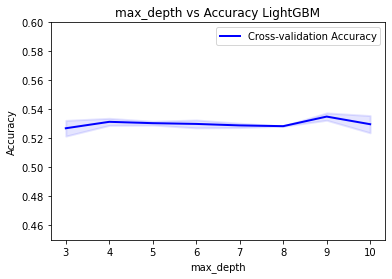

In [74]:
params = {
    'max_depth': range(3, 11)
}
lgb = LGBMClassifier(objective='multiclass',num_class=4, random_state=1, learning_rate=0.17, n_jobs=-1)
grid = GridSearchCV(return_train_score=True, estimator=lgb, param_grid=params, cv=2, n_jobs=-1, scoring=['accuracy', 'roc_auc_ovo'], refit='accuracy', verbose=10)
grid.fit(X_train,y_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
plot_grid_search_validation_curve(grid, 'max_depth', model_name='LightGBM')

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  36 out of  60 | elapsed:   13.7s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  43 out of  60 | elapsed:   17.7s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  50 out of  60 | elapsed:   18.7s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed:   21.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   22.2s finished



 The best estimator across ALL searched params:
 LGBMClassifier(learning_rate=0.17, num_class=4, num_leaves=10,
               objective='multiclass', random_state=1)

 The best score across ALL searched params:
 0.5351723228415685

 The best parameters across ALL searched params:
 {'num_leaves': 10}


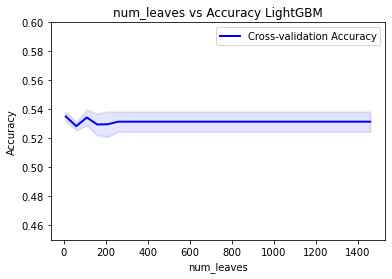

In [75]:
params = {
    'num_leaves': np.arange(10, 1500, 50)
}
lgb = LGBMClassifier(objective='multiclass',num_class=4, random_state=1, learning_rate=0.17, n_jobs=-1)
grid = GridSearchCV(return_train_score=True, estimator=lgb, param_grid=params, cv=2, n_jobs=-1, scoring=['accuracy', 'roc_auc_ovo'], refit='accuracy', verbose=10)
grid.fit(X_train,y_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
plot_grid_search_validation_curve(grid, 'num_leaves', model_name='LightGBM')

Fitting 2 folds for each of 29 candidates, totalling 58 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  33 out of  58 | elapsed:    4.3s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  39 out of  58 | elapsed:    4.5s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  45 out of  58 | elapsed:    4.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  51 out of  58 | elapsed:    5.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    5.9s finished



 The best estimator across ALL searched params:
 LGBMClassifier(learning_rate=0.17, min_child_samples=2, num_class=4,
               objective='multiclass', random_state=1)

 The best score across ALL searched params:
 0.5370310374026266

 The best parameters across ALL searched params:
 {'min_child_samples': 2}


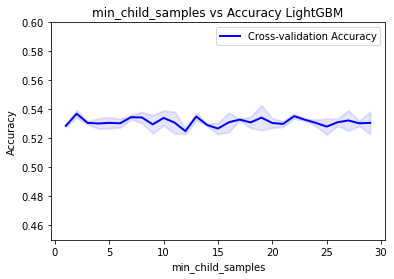

In [76]:
params = {
    'min_child_samples': range(1, 30)
}
lgb = LGBMClassifier(objective='multiclass',num_class=4, random_state=1, learning_rate=0.17, n_jobs=-1)
grid = GridSearchCV(return_train_score=True, estimator=lgb, param_grid=params, cv=2, n_jobs=-1, scoring=['accuracy', 'roc_auc_ovo'], refit='accuracy', verbose=10)
grid.fit(X_train,y_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
plot_grid_search_validation_curve(grid, 'min_child_samples', model_name='LightGBM')

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    1.3s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:    1.4s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    1.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.4s finished



 The best estimator across ALL searched params:
 LGBMClassifier(learning_rate=0.17, num_class=4, objective='multiclass',
               random_state=1)

 The best score across ALL searched params:
 0.5306273377708656

 The best parameters across ALL searched params:
 {'min_child_weight': 0.001}


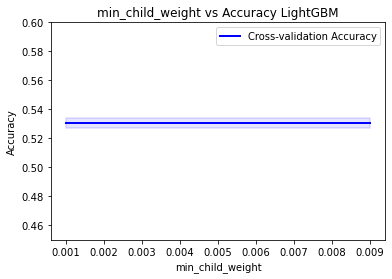

In [77]:
params = {
    'min_child_weight': np.arange(0.001, 0.01, 0.001)
}
lgb = LGBMClassifier(objective='multiclass',num_class=4, random_state=1, learning_rate=0.17, n_jobs=-1)
grid = GridSearchCV(return_train_score=True, estimator=lgb, param_grid=params, cv=2, n_jobs=-1, scoring=['accuracy', 'roc_auc_ovo'], refit='accuracy', verbose=10)
grid.fit(X_train,y_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
plot_grid_search_validation_curve(grid, 'min_child_weight', model_name='LightGBM')

Fitting 2 folds for each of 11 candidates, totalling 22 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  22 | elapsed:    1.5s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   6 out of  22 | elapsed:    1.5s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   9 out of  22 | elapsed:    1.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    1.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  15 out of  22 | elapsed:    1.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  18 out of  22 | elapsed:    2.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    2.8s finished



 The best estimator across ALL searched params:
 LGBMClassifier(learning_rate=0.17, num_class=4, objective='multiclass',
               random_state=1, reg_alpha=0.8)

 The best score across ALL searched params:
 0.5341395424072275

 The best parameters across ALL searched params:
 {'reg_alpha': 0.8}


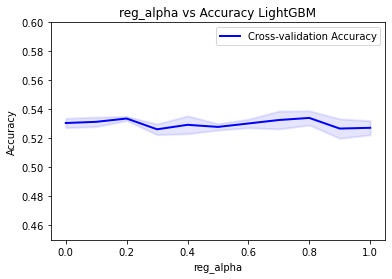

In [78]:
params = {
    'reg_alpha': np.arange(0.0, 1.1, 0.1)
}
lgb = LGBMClassifier(objective='multiclass',num_class=4, random_state=1, learning_rate=0.17, n_jobs=-1)
grid = GridSearchCV(return_train_score=True, estimator=lgb, param_grid=params, cv=2, n_jobs=-1, scoring=['accuracy', 'roc_auc_ovo'], refit='accuracy', verbose=10)
grid.fit(X_train,y_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
plot_grid_search_validation_curve(grid, 'reg_alpha', model_name='LightGBM')

Fitting 2 folds for each of 11 candidates, totalling 22 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  22 | elapsed:    1.4s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done   6 out of  22 | elapsed:    1.4s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   9 out of  22 | elapsed:    1.5s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:    1.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  15 out of  22 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  18 out of  22 | elapsed:    2.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    2.7s finished



 The best estimator across ALL searched params:
 LGBMClassifier(learning_rate=0.17, num_class=4, objective='multiclass',
               random_state=1, reg_lambda=1.0)

 The best score across ALL searched params:
 0.5380647354467095

 The best parameters across ALL searched params:
 {'reg_lambda': 1.0}


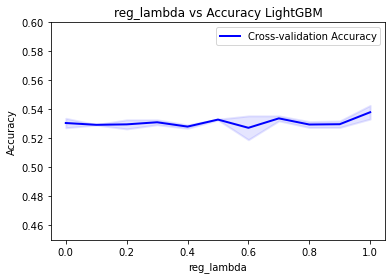

In [79]:
params = {
    'reg_lambda': np.arange(0.0, 1.1, 0.1)
}
lgb = LGBMClassifier(objective='multiclass',num_class=4, random_state=1, learning_rate=0.17, n_jobs=-1)
grid = GridSearchCV(return_train_score=True, estimator=lgb, param_grid=params, cv=2, n_jobs=-1, scoring=['accuracy', 'roc_auc_ovo'], refit='accuracy', verbose=10)
grid.fit(X_train,y_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
plot_grid_search_validation_curve(grid, 'reg_lambda', model_name='LightGBM')

Fitting 2 folds for each of 29 candidates, totalling 58 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  33 out of  58 | elapsed:    6.4s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  39 out of  58 | elapsed:    6.7s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  45 out of  58 | elapsed:    6.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  51 out of  58 | elapsed:    7.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    8.1s finished



 The best estimator across ALL searched params:
 LGBMClassifier(learning_rate=0.04, num_class=4, objective='multiclass',
               random_state=1)

 The best score across ALL searched params:
 0.5373417443291718

 The best parameters across ALL searched params:
 {'learning_rate': 0.04}


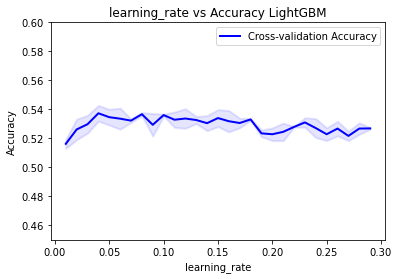

In [82]:
params = {
    'learning_rate': np.arange(0.01, 0.3, 0.01)
}
lgb = LGBMClassifier(objective='multiclass',num_class=4, random_state=1, learning_rate=0.17, n_jobs=-1)
grid = GridSearchCV(return_train_score=True, estimator=lgb, param_grid=params, cv=2, n_jobs=-1, scoring=['accuracy', 'roc_auc_ovo'], refit='accuracy', verbose=10)
grid.fit(X_train,y_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
plot_grid_search_validation_curve(grid, 'learning_rate', model_name='LightGBM')

In [58]:
lgb = LGBMClassifier(objective='multiclass',num_class=4, random_state=1, learning_rate=0.074, n_jobs=-1, 
                     max_depth=9, num_leaves=151,  min_child_samples=3, min_child_weight=0.009,
                   reg_alpha=0.5, reg_lambda=0.6)
model_eval(lgb)

Train: Acc: 0.97165 +/- 0.00461,  Auc: 0.99854 | Test: Acc: 0.56379 +/- 0.02714,  Auc: 0.80478


(0.9716511954999639,
 0.9985403889605514,
 0.5637855120299533,
 0.8047785769290776)

# RF Tuning

In [49]:
rf = RandomForestClassifier(n_estimators=887, criterion='gini', max_depth=None,random_state=1,
                            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                            max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                            min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=-1,
                            verbose=0, warm_start=False, class_weight=None)
model_eval(rf)

Train: Acc: 1.00000 +/- 0.00000,  Auc: 1.00000 | Test: Acc: 0.56007 +/- 0.04154,  Auc: 0.80941


(1.0, 1.0, 0.5600651178261649, 0.8094091706324203)

Fitting 2 folds for each of 14 candidates, totalling 28 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  28 | elapsed:    3.0s remaining:   25.9s
[Parallel(n_jobs=-1)]: Done   6 out of  28 | elapsed:    3.2s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done   9 out of  28 | elapsed:    6.3s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  12 out of  28 | elapsed:    7.5s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  15 out of  28 | elapsed:   11.7s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  18 out of  28 | elapsed:   15.7s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  21 out of  28 | elapsed:   18.1s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  24 out of  28 | elapsed:   20.0s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   24.8s finished



 The best estimator across ALL searched params:
 RandomForestClassifier(n_estimators=1400, n_jobs=-1, random_state=1)

 The best score across ALL searched params:
 0.543023029016954

 The best parameters across ALL searched params:
 {'n_estimators': 1400}


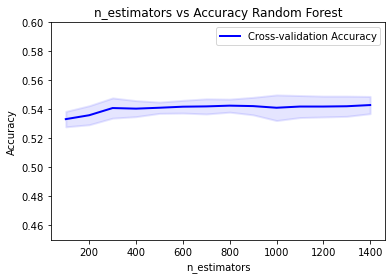

In [83]:
params = {
    'n_estimators': np.arange(100, 1500, 100),
}
rf = RandomForestClassifier(n_jobs=-1, min_samples_split=2, min_samples_leaf=1, random_state=1)
grid = GridSearchCV(return_train_score=True, estimator=rf, param_grid=params, cv=2, n_jobs=-1, scoring=['accuracy', 'roc_auc_ovo'], refit='accuracy', verbose=10)
grid.fit(X_train,y_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
plot_grid_search_validation_curve(grid, 'n_estimators', model_name='Random Forest')

Fitting 2 folds for each of 15 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:    0.9s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:    1.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:    2.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    2.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.4s finished



 The best estimator across ALL searched params:
 RandomForestClassifier(max_depth=18, n_jobs=-1, random_state=1)

 The best score across ALL searched params:
 0.5373414455725116

 The best parameters across ALL searched params:
 {'max_depth': 18}


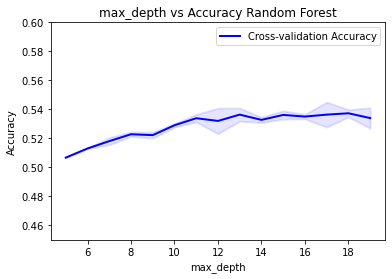

In [87]:
params = {
    'max_depth': range(5, 20)
}
rf = RandomForestClassifier(n_jobs=-1, min_samples_split=2, min_samples_leaf=1, random_state=1)
grid = GridSearchCV(return_train_score=True, estimator=rf, param_grid=params, cv=2, n_jobs=-1, scoring=['accuracy', 'roc_auc_ovo'], refit='accuracy', verbose=10)
grid.fit(X_train,y_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
plot_grid_search_validation_curve(grid, 'max_depth', model_name='Random Forest')

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.8s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished



 The best estimator across ALL searched params:
 RandomForestClassifier(min_samples_split=4, n_jobs=-1, random_state=1)

 The best score across ALL searched params:
 0.537858145216223

 The best parameters across ALL searched params:
 {'min_samples_split': 4}


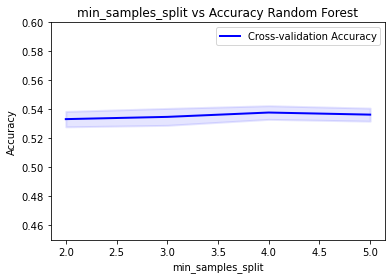

In [88]:
params = {
    "min_samples_split": [1, 2, 3, 4, 5],
}
rf = RandomForestClassifier(n_jobs=-1, min_samples_split=2, min_samples_leaf=1, random_state=1)
grid = GridSearchCV(return_train_score=True, estimator=rf, param_grid=params, cv=2, n_jobs=-1, scoring=['accuracy', 'roc_auc_ovo'], refit='accuracy', verbose=10)
grid.fit(X_train,y_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
plot_grid_search_validation_curve(grid, 'min_samples_split', model_name='Random Forest')

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.8s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished



 The best estimator across ALL searched params:
 RandomForestClassifier(n_jobs=-1, random_state=1)

 The best score across ALL searched params:
 0.5333132241648044

 The best parameters across ALL searched params:
 {'min_samples_leaf': 1}


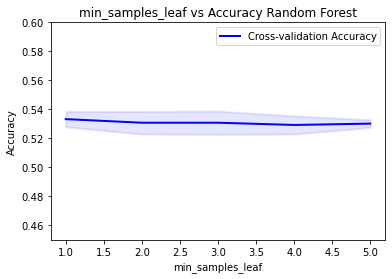

In [89]:
params = {
    "min_samples_leaf": [1, 2, 3, 4, 5]
}
rf = RandomForestClassifier(n_jobs=-1, min_samples_split=2, min_samples_leaf=1, random_state=1)
grid = GridSearchCV(return_train_score=True, estimator=rf, param_grid=params, cv=2, n_jobs=-1, scoring=['accuracy', 'roc_auc_ovo'], refit='accuracy', verbose=10)
grid.fit(X_train,y_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
plot_grid_search_validation_curve(grid, 'min_samples_leaf', model_name='Random Forest')

In [14]:
rf = RandomForestClassifier(n_jobs=-1, random_state=1, 
                            max_depth=19,n_estimators=1300,
                           min_samples_leaf=1, min_samples_split=2, bootstrap=True, oob_score=True)
model_eval(rf)

Train: Acc: 0.99207 +/- 0.00093,  Auc: 0.99971 | Test: Acc: 0.56161 +/- 0.03801,  Auc: 0.80943


(0.9920692268511097,
 0.9997137057593756,
 0.5616148112137417,
 0.8094318578626869)

# XGBoost Tuning

In [15]:
xgb = XGBClassifier(
        n_estimators=670,
        learning_rate= 0.01,
        max_depth=6,
        subsample=1, 
        gamma=0, 
        reg_lambda=1,
        max_delta_step=0,
        colsample_bytree=1, 
        min_child_weight=1, 
        random_state=1,
        eval_metric= 'auc',
        n_jobs=-1)

model_eval(xgb)

Train: Acc: 0.72370 +/- 0.00693,  Auc: 0.91856 | Test: Acc: 0.55190 +/- 0.02673,  Auc: 0.80003


(0.7236970102198914,
 0.9185566943993058,
 0.5519048136871103,
 0.8000259975855389)

In [19]:
xgb = XGBClassifier(
    learning_rate= 0.17,
    random_state=1,
    n_jobs=-1,
    eval_metric= 'auc'
)
model_eval(xgb)

Train: Acc: 0.83229 +/- 0.01174,  Auc: 0.96696 | Test: Acc: 0.55149 +/- 0.03586,  Auc: 0.80271


(0.8322945935782815, 0.9669564742428742, 0.551492336821636, 0.8027099885947953)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    6.3s remaining:   19.0s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    6.4s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    6.4s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    6.4s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    6.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.8s finished



 The best estimator across ALL searched params:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.17, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.8999999999999999, tree_method='exact',
              validate_parameters=1, verbosity=None)

 The best score across ALL searched params:
 0.537135090079401

 The best parameters across ALL searched params:
 {'subsample': 0.8999999999999999}


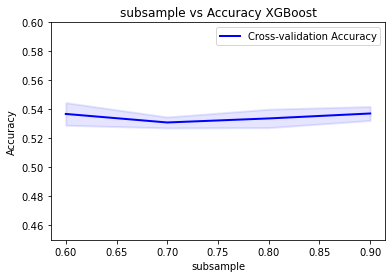

In [90]:
params = {
    'subsample': np.arange(0.6, 1.0, 0.1),
}
xgb = XGBClassifier(
    learning_rate= 0.17,
    random_state=1,
    n_jobs=-1,
    eval_metric= 'auc'
)
grid = GridSearchCV(return_train_score=True, estimator=xgb, param_grid=params, cv=2, n_jobs=-1, scoring=['accuracy', 'roc_auc_ovo'], refit='accuracy', verbose=10)
grid.fit(X_train,y_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
plot_grid_search_validation_curve(grid, 'subsample', model_name='XGBoost')

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    4.4s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    4.5s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    4.7s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    5.0s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    5.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    5.3s finished



 The best estimator across ALL searched params:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.17, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

 The best score across ALL searched params:
 0.5399240902006108

 The best parameters across ALL searched params:
 {'colsample_bytree': 0.7}


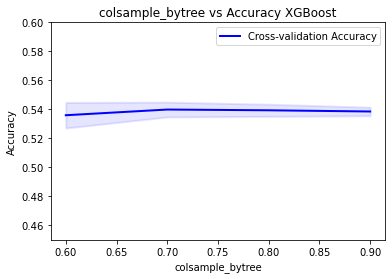

In [91]:
params = {
    'colsample_bytree': np.arange(0.6, 1.0, 0.1),
}
xgb = XGBClassifier(
    learning_rate= 0.17,
    random_state=1,
    n_jobs=-1,
    eval_metric= 'auc'
)
grid = GridSearchCV(return_train_score=True, estimator=xgb, param_grid=params, cv=2, n_jobs=-1, scoring=['accuracy', 'roc_auc_ovo'], refit='accuracy', verbose=10)
grid.fit(X_train,y_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
plot_grid_search_validation_curve(grid, 'colsample_bytree', model_name='XGBoost')

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    3.9s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    4.2s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    4.3s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    4.6s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    4.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    5.0s finished



 The best estimator across ALL searched params:
 XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.8999999999999999, colsample_bynode=1,
              colsample_bytree=1, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.17, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

 The best score across ALL searched params:
 0.5361023950041057

 The best parameters across ALL searched params:
 {'colsample_bylevel': 0.8999999999999999}


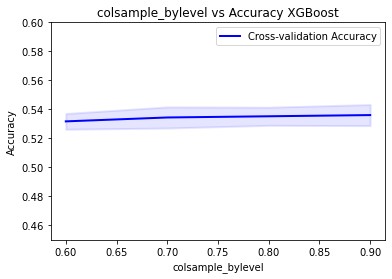

In [92]:
params = {
    'colsample_bylevel': np.arange(0.6, 1.0, 0.1),
}
xgb = XGBClassifier(
    learning_rate= 0.17,
    random_state=1,
    n_jobs=-1,
    eval_metric= 'auc'
)
grid = GridSearchCV(return_train_score=True, estimator=xgb, param_grid=params, cv=2, n_jobs=-1, scoring=['accuracy', 'roc_auc_ovo'], refit='accuracy', verbose=10)
grid.fit(X_train,y_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
plot_grid_search_validation_curve(grid, 'colsample_bylevel', model_name='XGBoost')

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 190 out of 200 | elapsed:  1.5min remaining:    4.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished



 The best estimator across ALL searched params:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.17, max_delta_step=0,
              max_depth=6, min_child_weight=7.4, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

 The best score across ALL searched params:
 0.5402337514788456

 The best parameters across ALL searched params:
 {'min_child_weight': 7.4}


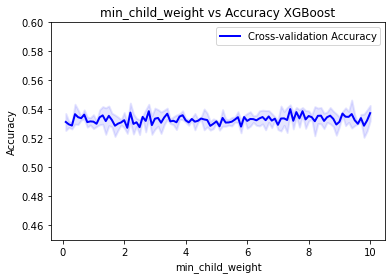

In [93]:
params = {
    'min_child_weight': np.arange(0.1, 10.1, 0.1)
}
xgb = XGBClassifier(
    learning_rate= 0.17,
    random_state=1,
    n_jobs=-1,
    eval_metric= 'auc'
)
grid = GridSearchCV(return_train_score=True, estimator=xgb, param_grid=params, cv=2, n_jobs=-1, scoring=['accuracy', 'roc_auc_ovo'], refit='accuracy', verbose=10)
grid.fit(X_train,y_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
plot_grid_search_validation_curve(grid, 'min_child_weight', model_name='XGBoost')

Fitting 2 folds for each of 15 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   14.4s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:   29.2s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:   43.0s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   58.2s remaining:   58.2s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  1.4min remaining:   50.0s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.8min remaining:   33.4s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  2.2min remaining:   14.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.3min finished



 The best estimator across ALL searched params:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.17, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

 The best score across ALL searched params:
 0.5339327387791266

 The best parameters across ALL searched params:
 {'n_estimators': 300}


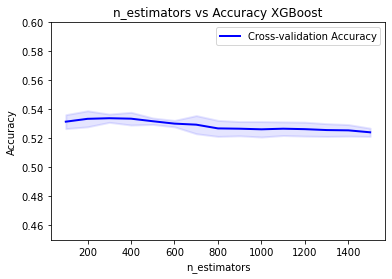

In [94]:
params = {
    'n_estimators': np.arange(100, 1600, 100),
}
xgb = XGBClassifier(
    learning_rate= 0.17,
    random_state=1,
    n_jobs=-1,
    eval_metric= 'auc'
)
grid = GridSearchCV(return_train_score=True, estimator=xgb, param_grid=params, cv=2, n_jobs=-1, scoring=['accuracy', 'roc_auc_ovo'], refit='accuracy', verbose=10)
grid.fit(X_train,y_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
plot_grid_search_validation_curve(grid, 'n_estimators', model_name='XGBoost')

In [ ]:
params = {
    'max_depth': range(3, 13)
}
xgb = XGBClassifier(
    learning_rate= 0.17,
    random_state=1,
    n_jobs=-1,
    eval_metric= 'auc'
)
grid = GridSearchCV(return_train_score=True, estimator=xgb, param_grid=params, cv=2, n_jobs=-1, scoring=['accuracy', 'roc_auc_ovo'], refit='accuracy', verbose=10)
grid.fit(X_train,y_train)

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)
plot_grid_search_validation_curve(grid, 'max_depth', model_name='XGBoost')

In [13]:
xgb = XGBClassifier(
    colsample_bylevel=0.6,
    colsample_bytree=0.7,
    subsample=0.8999,
    random_state=1,
    n_jobs=-1,
    min_child_weight=0.4,
    max_depth=12,
    n_estimators=210,
    learning_rate=0.05,
    eval_metric= 'auc'
)
model_eval(xgb)

Train: Acc: 0.99984 +/- 0.00021,  Auc: 1.00000 | Test: Acc: 0.56637 +/- 0.03694,  Auc: 0.81222


(0.9998393192381018,
 0.9999999826794903,
 0.5663660244437054,
 0.8122189684499043)

# Stack Tuning

In [36]:
rf = RandomForestClassifier(n_jobs=-1, random_state=1, 
                            max_depth=19,n_estimators=1300,
                           min_samples_leaf=1, min_samples_split=2, bootstrap=True, oob_score=True)

xgb = XGBClassifier(
    colsample_bylevel=0.6,
    colsample_bytree=0.7,
    subsample=0.8999,
    random_state=1,
    n_jobs=-1,
    min_child_weight=0.4,
    max_depth=12,
    n_estimators=210,
    learning_rate=0.05,
    eval_metric= 'auc'
)


lgb = LGBMClassifier(objective='multiclass',num_class=4, random_state=1, learning_rate=0.074, n_jobs=-1, 
                     max_depth=9, num_leaves=151,  min_child_samples=3, min_child_weight=0.009,
                   reg_alpha=0.5, reg_lambda=0.6)

cat = CatBoostClassifier(
    verbose=False, 
    random_state=1, 
    thread_count=-1,
    rsm=0.8,
    depth=7,
    iterations=1000
)

estimators = [
    ('rf', rf),
    ('xgb', xgb),
    ('lgb', lgb)
#     ('cat', cat)
]

params = {'C': [0.1, 1, 10, 100, 1000]
#           'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale'], 
}

all_params = []
all_train_accs = []
all_train_aucs = []
all_test_accs = []
all_test_aucs = []


pbar = tqdm(ParameterGrid(params))
for param in pbar:
    stack = StackingClassifier(estimators=estimators, 
                               final_estimator=SVC(kernel='linear',
#                                                    gamma=param['gamma'],
                                                   C=param['C'],
                                                   random_state=1, probability=True), n_jobs=-1)
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    train_accs = []
    test_accs = []
    train_aucs = []
    test_aucs = []
    split_count = 1
    for train_index, test_index in kf.split(X_train):
        pbar.set_description('{} '.format(split_count)+str(param))
        X_train_k, X_test_k = X_train[train_index], X_train[test_index]
        y_train_k, y_test_k = y_train[train_index], y_train[test_index]
        stack.fit(X_train_k,y_train_k)

        y_train_ypred = stack.predict(X_train_k)
        y_train_prob = stack.predict_proba(X_train_k)

        y_test_ypred = stack.predict(X_test_k)
        y_test_prob = stack.predict_proba(X_test_k)

        train_acc, train_auc, test_acc, test_auc = metrics.accuracy_score(y_train_k, y_train_ypred), roc_auc_score(y_train_k, y_train_prob, multi_class='ovo'),metrics.accuracy_score(y_test_k, y_test_ypred), roc_auc_score(y_test_k, y_test_prob, multi_class='ovo')
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        train_aucs.append(train_auc)
        test_aucs.append(test_auc)
        split_count += 1
    train_accs = np.asarray(train_accs)
    test_accs = np.asarray(test_accs)
    train_aucs = np.asarray(train_aucs)
    test_aucs = np.asarray(test_aucs)

    print("Train: Acc: {:.5f} +/- {:.5f},  Auc: {:.5f} | Test: Acc: {:.5f} +/- {:.5f},  Auc: {:.5f}".
              format(train_accs.mean(), train_accs.std() * 2, train_aucs.mean(),
                     test_accs.mean(), test_accs.std() * 2, test_aucs.mean()))
    
    all_params.append(param)
    all_train_accs.append(train_accs)
    all_train_aucs.append(train_aucs)
    all_test_accs.append(test_accs)
    all_test_aucs.append(test_aucs)


1 {'C': 1}:  20%|█████████████████████████████▍                                                                                                                     | 1/5 [08:14<32:59, 494.89s/it]

Train: Acc: 0.99907 +/- 0.00085,  Auc: 1.00000 | Test: Acc: 0.56451 +/- 0.00775,  Auc: 0.81167


1 {'C': 10}:  40%|██████████████████████████████████████████████████████████▍                                                                                       | 2/5 [16:00<24:18, 486.16s/it]

Train: Acc: 0.99979 +/- 0.00039,  Auc: 1.00000 | Test: Acc: 0.56275 +/- 0.00687,  Auc: 0.81118


1 {'C': 100}:  60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [23:50<16:02, 481.21s/it]

Train: Acc: 0.99987 +/- 0.00023,  Auc: 1.00000 | Test: Acc: 0.56347 +/- 0.00752,  Auc: 0.81087


1 {'C': 1000}:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 4/5 [31:51<08:01, 481.09s/it]

Train: Acc: 0.99987 +/- 0.00023,  Auc: 1.00000 | Test: Acc: 0.56358 +/- 0.00889,  Auc: 0.81081


5 {'C': 1000}: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [48:26<00:00, 581.40s/it]

Train: Acc: 0.99987 +/- 0.00023,  Auc: 1.00000 | Test: Acc: 0.56347 +/- 0.00887,  Auc: 0.81082


In [41]:
mean_test_accs = [x.mean() for x in all_test_accs]
mean_test_aucs = [x.mean() for x in all_test_aucs]
print(mean_test_accs)
print(mean_test_aucs)
print('Best C:', all_params[mean_test_accs.index(max(mean_test_accs))])

[0.5645076095350652, 0.5627517845181054, 0.5634746050167039, 0.5635778574689496, 0.5634744983509474]
[0.8116732111692183, 0.8111841687308171, 0.8108694627409158, 0.8108104329506667, 0.8108164993032758]
Best C: {'C': 0.1}


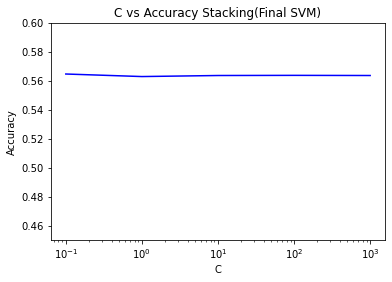

In [102]:
plt.plot([0.1, 1, 10, 100, 1000], [0.5645076095350652, 0.5627517845181054, 0.5634746050167039, 0.5635778574689496, 0.5634744983509474], color='b')
title = 'C' + ' vs Accuracy ' + 'Stacking(Final SVM)'
plt.title(title)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.ylim(0.45, 0.6)
plt.show()

# Stacking

Train ACC: 0.99964  Train Auc: 1.00000  Test ACC: 0.59532  Test Auc: 0.83291 


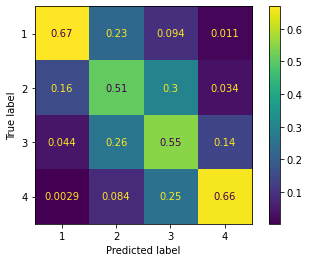

Classification Report: 
               precision    recall  f1-score   support

           1      0.761     0.669     0.712       362
           2      0.482     0.509     0.496       379
           3      0.460     0.551     0.501       365
           4      0.768     0.660     0.710       347

    accuracy                          0.595      1453
   macro avg      0.618     0.597     0.605      1453
weighted avg      0.615     0.595     0.602      1453



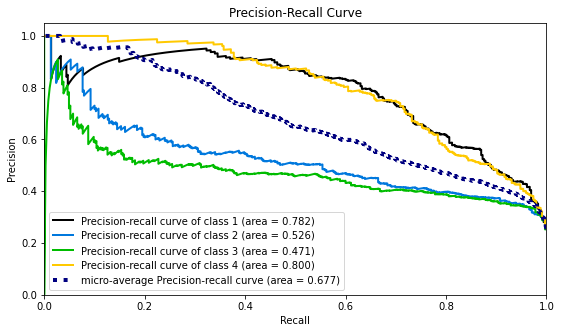

In [14]:
train_data = pd.read_csv("train.csv",encoding="utf_8_sig")
train_data = data_processing_onehotencode(train_data)
X = train_data.drop(columns=['price'], axis=1)
y = train_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2020)
scale = StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

rf = RandomForestClassifier(n_jobs=-1, random_state=1, 
                            max_depth=19,n_estimators=1300,
                           min_samples_leaf=1, min_samples_split=2, bootstrap=True, oob_score=True)

xgb = XGBClassifier(
    colsample_bylevel=0.6,
    colsample_bytree=0.7,
    subsample=0.8999,
    random_state=1,
    n_jobs=-1,
    min_child_weight=0.4,
    max_depth=12,
    n_estimators=210,
    learning_rate=0.05,
    eval_metric= 'auc'
)


lgb = LGBMClassifier(objective='multiclass',num_class=4, random_state=1, learning_rate=0.074, n_jobs=-1, 
                     max_depth=9, num_leaves=151,  min_child_samples=3, min_child_weight=0.009,
                   reg_alpha=0.5, reg_lambda=0.6)

cat = CatBoostClassifier(
    verbose=False, 
    random_state=1, 
    thread_count=-1,
    rsm=0.8,
    depth=7,
    iterations=1000
)

estimators = [
    ('rf', rf),
    ('xgb', xgb),
    ('lgb', lgb)
#     ('cat', cat)
]

stack = StackingClassifier(estimators=estimators, final_estimator=SVC(kernel='linear', random_state=1, probability=True), n_jobs=-1)
# model_eval(stack)
stack.fit(X_train,y_train)
y_train_ypred = stack.predict(X_train)
y_train_prob = stack.predict_proba(X_train)

y_test_ypred = stack.predict(X_test)
y_test_prob = stack.predict_proba(X_test)
y_probas = stack.predict_proba(X_test)

train_acc, train_auc, test_acc, test_auc = metrics.accuracy_score(y_train, y_train_ypred), roc_auc_score(y_train, y_train_prob, multi_class='ovo'),metrics.accuracy_score(y_test, y_test_ypred), roc_auc_score(y_test, y_test_prob, multi_class='ovo')
print("Train ACC: {:<8.5f} Train Auc: {:<8.5f} Test ACC: {:<8.5f} Test Auc: {:<8.5f}".format(train_acc, train_auc, test_acc, test_auc))

plot_confusion_matrix(stack, X_test, y_test, normalize='true')
plt.show() 
print('='*100)
print('Classification Report: \n', classification_report(y_test, y_test_ypred, digits=3))
print('='*100)

skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(9,5))
plt.show()

# Submission

In [19]:
def create_submission(clf, data_process_function, output='my_submission.csv'):
    submission_data_raw = pd.read_csv("test.csv",encoding="utf_8_sig")
    submission_data = data_process_function(submission_data_raw)
    submission_result = pd.DataFrame()
    X_submission = submission_data
    X_submission = scale.transform(X_submission)
    y_submission = stack.predict(X_submission)
    submission_result['id'] = submission_data_raw['id']
    submission_result['price'] = y_submission
    submission_result.to_csv(output, index=False)
    print(submission_data_raw.shape, submission_result.shape)
#     pickle.dump(stack, open('models/stack_56993.pkl', 'wb'))

In [20]:
create_submission(stack, data_processing_onehotencode, output='exp.csv')

(4149, 25) (4149, 2)


In [21]:
pickle.dump(stack, open('models/stack_58038.pkl', 'wb'))